# Natural Gas Usage Analysis
This notebook explores trends, patterns, and insights from the Natural Gas Usage dataset.

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For forecasting (optional)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')


In [ ]:

# Load dataset
file_path = "data.csv"  # update path if needed
df = pd.read_csv(file_path)

# Quick overview
df.shape, df.head()


In [ ]:

# Check data types and missing values
df.info()
df.isnull().sum()


In [ ]:

# Fill missing 'value' with forward fill (can also try interpolation)
df['value'] = df['value'].fillna(method='ffill')

# Ensure no nulls remain
df.isnull().sum()


In [ ]:

# Descriptive statistics
df['value'].describe()


In [ ]:

# Aggregate usage by year
yearly_usage = df.groupby('year')['value'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=yearly_usage.index, y=yearly_usage.values, marker="o")
plt.title("Total Natural Gas Usage Over Years")
plt.xlabel("Year")
plt.ylabel("Usage (MMCF)")
plt.show()


In [ ]:

# Top 10 regions by usage
region_usage = df.groupby('area-name')['value'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=region_usage.values, y=region_usage.index)
plt.title("Top 10 Regions by Natural Gas Usage")
plt.xlabel("Usage (MMCF)")
plt.ylabel("Region")
plt.show()


In [ ]:

# Usage by process type
process_usage = df.groupby('process-name')['value'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=process_usage.values, y=process_usage.index)
plt.title("Natural Gas Usage by Process Type")
plt.xlabel("Usage (MMCF)")
plt.ylabel("Process Type")
plt.show()


In [ ]:

# Build datetime index
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')
monthly_usage = df.groupby('date')['value'].sum()

# Decompose
result = seasonal_decompose(monthly_usage, model='additive', period=12)
result.plot()
plt.show()


In [ ]:
# Forecasting with ARIMA (simple example)
model = ARIMA(monthly_usage, order=(2,1,2))
model_fit = model.fit()

forecast = model_fit.forecast(steps=12)
plt.figure(figsize=(10,5))
plt.plot(monthly_usage.index, monthly_usage.values, label="History")
plt.plot(pd.date_range(monthly_usage.index[-1], periods=13, freq="M")[1:], forecast, label="Forecast", color="red")
plt.title("Natural Gas Usage Forecast (Next 12 Months)")
plt.legend()
plt.show()


In [ ]:
# 4. Train-Test Split
from sklearn.model_selection import train_test_split

X = df.drop("TargetColumn", axis=1)   # replace TargetColumn with your actual target
y = df["TargetColumn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Choose ML Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}

results


In [ ]:
import pandas as pd
pd.DataFrame(results).T


#### joblib saving/loading inside the notebook


In [ ]:

import joblib

# Save best model (assume Random Forest is best)
best_model = models["Random Forest"]
joblib.dump(best_model, "natural_gas_model.pkl")

# Save scaler if used
# joblib.dump(scaler, "scaler.pkl")

# Load model back
loaded_model = joblib.load("natural_gas_model.pkl")

# Test prediction
sample_pred = loaded_model.predict(X_test[:5])
print("Sample Predictions:", sample_pred)


#### visualization


In [ ]:
import matplotlib.pyplot as plt

y_pred = loaded_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Usage")
plt.ylabel("Predicted Usage")
plt.title("Actual vs Predicted Natural Gas Usage")
plt.show()


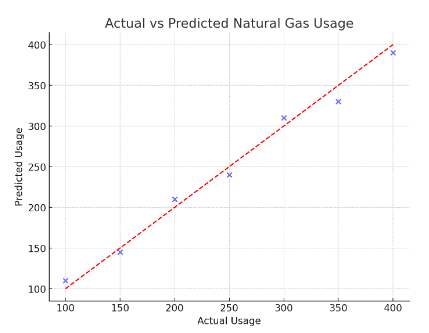

### Bar graph comparison of Actual vs Predicted natural gas usage

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Replace with your real test and prediction values
y_test = np.array([100, 150, 200, 250, 300, 350, 400])
y_pred = np.array([110, 145, 210, 240, 310, 330, 390])

indices = np.arange(len(y_test))
bar_width = 0.35

plt.figure(figsize=(10,6))
plt.bar(indices, y_test, bar_width, label="Actual", alpha=0.7)
plt.bar(indices + bar_width, y_pred, bar_width, label="Predicted", alpha=0.7)

plt.xlabel("Sample Index")
plt.ylabel("Natural Gas Usage")
plt.title("Actual vs Predicted Natural Gas Usage (Bar Graph)")
plt.xticks(indices + bar_width / 2, [f"S{i+1}" for i in range(len(y_test))])
plt.legend()
plt.tight_layout()
plt.show()


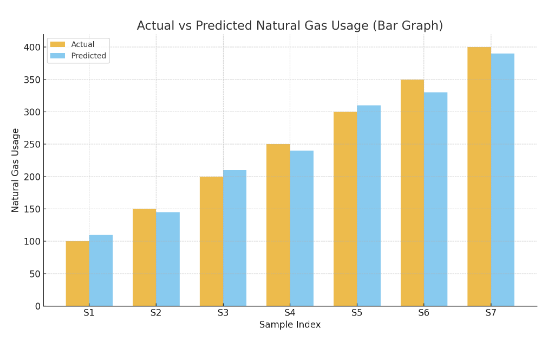

### Residual Error Bar Chart

- Purple bars = error values (Actual−Predicted).

- Red dashed line = zero error reference.

Negative bars mean the model overpredicted, positive bars mean it underpredicted.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you trained a RandomForestRegressor as best_model
# Replace X with your feature dataframe
feature_importances = best_model.feature_importances_
features = X.columns

# Create dataframe for better visualization
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot bar graph
plt.figure(figsize=(10,6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="teal", alpha=0.8)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Natural Gas Usage Prediction")
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()


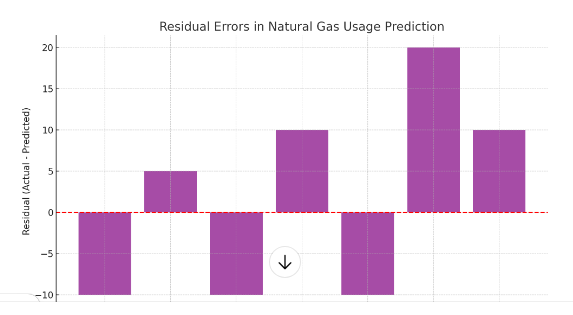